## Problem Statement
#### Compare return on investment for a rental property that is offered on the private market vs on AirBnb


## US Markets to Explore,
* San Francisco 
* New York
* Las Vegas
* Lake Tahoe
* Miami
* Los Angeles

### Property Type
The property must be an Apartment, House, Condominium, Townhouse, with a minimum of 1 bedroom and maximum of 4 bedrooms.



Data Obtained from:
Airbnb
Zillow
Redfin

#### SF, NY
Murray Cox, 2018, “Detailed Listings data for San Francisco”, Inside Airbnb, http://insideairbnb.com/get-the-data.html

#### Explore the following Datasets

* AirBnb
* Zillow
* Redfin

In [1]:
#Import libraries
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
from numpy.random import seed
from numpy.random import randn
from numpy import exp
from numpy import mean
from numpy import std

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import scipy.stats as stats
from scipy.stats import boxcox

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import median_absolute_error

import re


#Set display options
pd.set_option('display.max_columns', None)

C:\Users\moham\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Create initial DataFrame
df_sf = pd.DataFrame()
sf_df = pd.read_csv('..\\Data\\San Francisco Data\\listings.csv.gz',
                   error_bad_lines=False)
sf_df = df_sf.append(sf_df)

In [46]:
import pandas_profiling;
pandas_profiling.ProfileReport(df_sf)



Number of variables,64
Number of observations,5586
Total Missing (%),0.0%
Total size in memory,1.3 MiB
Average record size in memory,242.0 B
Numeric,18
Categorical,4
Boolean,41
Date,0
Text (Unique),0
Rejected,1


In [5]:
#Function to preprocess data
def preprocess(df):
    
    #Standardize column names
    df.columns = df.columns.str.strip()
    
    #Keep columns of interest
    df = df[['bathrooms','bedrooms','accommodates','price','monthly_price',\
             'property_type','zipcode','neighbourhood_cleansed','amenities','availability_365',\
             'number_of_reviews','review_scores_rating','review_scores_accuracy',\
             'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',\
             'review_scores_value']]
    
    #Might include the following
    #'availability_30','availability_60',\'availability_90',
                              
    #Update property types
    #Modify listing names that might be considered a condo
    condo_list=['Guesthouse','Bungalow','Tiny house','Cottage']
    df = update_property_value('property_type',condo_list,'Condominium', df)
    
    #Modify listing names that might be considered an apartment
    apartment_list = ['Serviced apartment','Aparthotel','Timeshare']
    df = update_property_value('property_type',apartment_list,'Apartment', df)
    
    #Modify listing names that might be considered an apartment
    house_list = ['Hostel','Boutique hotel','Bed and breakfast','Villa','Cabin','Earth house']
    df = update_property_value('property_type',house_list,'House', df)
    
    #Keep properties that are an Apartment Townhouse Condominium or House
    df = df.loc[(df['property_type'] == 'Apartment') | (df['property_type'] == 'Townhouse') | (df['property_type'] == 'Condominium')\
                | (df['property_type'] == 'House')]
    
    #Update column names
    df.rename(columns={'neighbourhood_cleansed': 'neighborhood','price': 'nightly_rental_$','cleaning_fee':'cleaning_fee_$',\
                       'monthly_price':'monthly_rental_$'}, inplace=True)
    
    #Drop bedroom data with non values and convert to integer type
    df = df[np.isfinite(df['bedrooms'])]
    df['bedrooms']= df['bedrooms'].astype(int)
    
    #Drop bedroom data with non values and convert to integer type
    df = df[np.isfinite(df['bathrooms'])]
    
    #Drop rows with 0 bedrooms or bedrooms less than 7 bedrooms
    df = df[(df.bedrooms > 0) & (df.bedrooms <=4)]
    
    #Modify string dollar value of nightly price to float
    df['nightly_rental_$']=df['nightly_rental_$'].replace('[\$,]', '', regex=True).astype(float)
        
    #Update monthly price by multiplying each value of nightly_rental by 30
    df['monthly_rental_$']=df['nightly_rental_$']*30
      
    return df

def update_property_value(column_name,listing_list, updated_listing_name,df):
    for listing in listing_list:
        df[column_name].replace(listing, updated_listing_name, inplace=True)
    return df

In [6]:
df_sf = preprocess(sf_df)

C:\Users\moham\Anaconda3\lib\site-packages\pandas\core\generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [7]:
#Determine number of listings per property_type
def number_of_listing(df):
    dicts = {}
    keys = df.property_type.unique()
    for i in keys:
        dicts[i] = len(df[df.property_type==str(i)])
    
    return dicts

sf_listing_dict = number_of_listing(df_sf)

In [8]:
print(sf_listing_dict)

{'Apartment': 2686, 'House': 2133, 'Condominium': 781, 'Townhouse': 137}


In [9]:
#Calculate average of reivew columns
#mean_availability_30 = df_sf['availability_30'].mean(skipna=True)
#mean_availability_60 = df_sf['availability_60'].mean(skipna=True)
#mean_availability_90 = df_sf['availability_90'].mean(skipna=True)
mean_availability_365 = df_sf['availability_365'].mean(skipna=True)
mean_num_reviews = df_sf['number_of_reviews'].mean(skipna=True)
mean_scores_rating = df_sf['review_scores_rating'].mean(skipna=True)
mean_score_accur = df_sf['review_scores_accuracy'].mean(skipna=True)
mean_score_clean = df_sf['review_scores_cleanliness'].mean(skipna=True)
mean_score_checkin = df_sf['review_scores_checkin'].mean(skipna=True)
mean_score_comm = df_sf['review_scores_communication'].mean(skipna=True)
mean_score_loc = df_sf['review_scores_location'].mean(skipna=True)
mean_review_score= df_sf['review_scores_value'].mean(skipna=True)

In [10]:
#Replace column NaN values with mean of column
#df_sf['availability_30'].fillna(int(round(mean_availability_30)), inplace=True)
#df_sf['availability_60'].fillna(int(round(mean_availability_60)), inplace=True)
#df_sf['availability_90'].fillna(int(round(mean_availability_90)), inplace=True)
df_sf['availability_365'].fillna(int(round(mean_availability_365)), inplace=True)

df_sf['number_of_reviews'].fillna(int(round(mean_num_reviews)), inplace=True)
df_sf['review_scores_rating'].fillna(int(round(mean_scores_rating)), inplace=True)
df_sf['review_scores_accuracy'].fillna(int(round(mean_score_accur)), inplace=True)
df_sf['review_scores_cleanliness'].fillna(int(round(mean_score_clean)), inplace=True)
df_sf['review_scores_checkin'].fillna(int(round(mean_score_checkin)), inplace=True)
df_sf['review_scores_communication'].fillna(int(round(mean_score_comm)), inplace=True)

df_sf['review_scores_location'].fillna(int(round(mean_score_loc)), inplace=True)
df_sf['review_scores_value'].fillna(int(round(mean_review_score)), inplace=True)

In [11]:
#Updated neighbourhood names in airbnb dataframe to match those from redfin
old_names = ['Ocean View ','Marina','Presidio','Downtown/Civic Center','Castro/Upper Market']
new_names = ['Ocean View Terrace','Marina District','Presidio Heights','Civic Center / Van Ness','Castro']

df_sf.replace('Ocean View', 'Ocean View Terrace', inplace=True)
df_sf.replace('Marina', 'Marina District',inplace=True)
df_sf.replace('Presidio', 'Presidio Heights',inplace=True)
df_sf.replace('Downtown/Civic Center', 'Civic Center / Van Ness',inplace=True)
df_sf.replace('Castro/Upper Market', 'Castro',inplace=True)


In [12]:
#Bring in zillow home value index and zillow rent index
xlsx_file_z_index = pd.ExcelFile('..\\Data\\San Francisco Data\\bedrooms_average.xlsx')
all_tier_z_index = pd.read_excel(xlsx_file_z_index, 'all_beds')


In [13]:
all_tier_z_index['Zillow Home Value Index $']=all_tier_z_index['Zillow Home Value Index $'].astype(np.int64)

In [14]:
all_tier_z_index['Zillow Rent Index $']=all_tier_z_index['Zillow Rent Index $'].astype(np.int64)

In [15]:
all_tier_z_index.head(5)

,neighborhood,bedrooms,Zillow Home Value Index $,Zillow Rent Index $
0,Bayview,1,1655879,3147
1,Bernal Heights,1,924100,3899
2,Castro,1,1655879,4775
3,Chinatown,1,1655879,4775
4,Civic Center / Van Ness,1,1655879,4775


In [16]:
all_tier_z_index.columns

Index(['neighborhood', 'bedrooms', 'Zillow Home Value Index $',
       'Zillow Rent Index $'],
      dtype='object')

In [17]:
#Add Zillow Home Value and Rent Index Information for individual neighborhoods
df_sf = pd.merge(df_sf, all_tier_z_index[['neighborhood', 'bedrooms', 'Zillow Home Value Index $']], left_on=['neighborhood','bedrooms'], right_on=['neighborhood','bedrooms']);

#Round Zillow Home Value Index to nearest integer
df_sf['Zillow Home Value Index $']=df_sf['Zillow Home Value Index $'].astype(np.int64)

In [18]:
df_sf.head(3)

,bathrooms,bedrooms,accommodates,nightly_rental_$,monthly_rental_$,property_type,zipcode,neighborhood,amenities,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,Zillow Home Value Index $
0,1.0,1,3,170.0,5100.0,Apartment,94117,Western Addition,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",64,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1053400
1,1.0,1,2,110.0,3300.0,Townhouse,94117,Western Addition,"{Wifi,Kitchen,""Pets live on this property"",Dog...",59,363,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1053400
2,1.0,1,2,110.0,3300.0,Townhouse,94117,Western Addition,"{Wifi,Kitchen,""Pets live on this property"",Dog...",44,399,98.0,10.0,10.0,10.0,10.0,10.0,9.0,1053400


# SF Walkability Info

In [19]:
#Bring in walkability and sales data from redfin
df_sf_info = pd.DataFrame()
sf_df_info = pd.read_csv('..\\Data\\San Francisco Data\\sf_walk_and_sale_df.csv')
sf_df_info = df_sf_info.append(sf_df_info)

In [20]:
#Clean additional Data Points
#Need to return to scrubbing function to address this issue
sf_df_info['walk_score_of_100'][2] = 81
sf_df_info['transit_score_of_100'][2] = 75
sf_df_info['bike_score_of_100'][2] = 71
sf_df_info['median_sale_price_$'][19] = '$1.25M'
sf_df_info['median_sale_price_$'][22] = '$1.01M'
sf_df_info['median_sale_price_$'][22] = '$1.01M'
sf_df_info['median_sale_price_$'][31] = '$761K'
sf_df_info['median_sale_price_$'][33] = '$1.35M'

C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\moham\Anaconda3\l

In [21]:
#Convert Median Home Prices to Int Value

def convert_string_to_int(df_column):
    for index, row in df_column.iteritems():
        if type(row) == float:
            pass
        elif (row[-1] == 'M') | (row[-1] == 'm'):
            number = re.findall("\d+\.\d+", row)
            df_column[index] = int(float(number[0])*1000000)
                      
        elif (row[-1] == 'K') | (row[-1] == 'k'):
            number = re.findall("\d+", row)
            df_column[index] = int(float(number[0])*1000)

    return df_column

sf_df_info['median_sale_price_$'] = convert_string_to_int(sf_df_info['median_sale_price_$'])

C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [22]:
#Calculate average of sf_df_info columns
mean_walk_score_of_100 = sf_df_info['walk_score_of_100'].mean(skipna=True)
mean_transit_score_of_100 = sf_df_info['transit_score_of_100'].mean(skipna=True)
mean_bike_score_of_100 = sf_df_info['bike_score_of_100'].mean(skipna=True)
mean_median_sale_price = sf_df_info['median_sale_price_$'].mean(skipna=True)

In [23]:
#Replace column NaN values with mean of column
sf_df_info['walk_score_of_100'].fillna(int(round(mean_walk_score_of_100)), inplace=True)
sf_df_info['transit_score_of_100'].fillna(int(round(mean_transit_score_of_100)), inplace=True)
sf_df_info['bike_score_of_100'].fillna(int(round(mean_bike_score_of_100)), inplace=True)
sf_df_info['median_sale_price_$'].fillna(int(round(mean_median_sale_price)), inplace=True)

In [24]:
#Save Cleaned SF Info Data to CSV
#Save data to csv file
sf_df_info.to_csv('..\Data\San Francisco Data\cleaned_sf_walk_and_sale_df.csv', index=False)

In [25]:
#Merge Walkability Info from Redfin to AirBnb Dataframe, merging on neighborhood
df_sf = pd.merge(df_sf, sf_df_info, left_on=['neighborhood'], right_on=['neighborhood']);

In [26]:
#Merge Walkability Info from Redfin to Zillow Dataframe, merging on neighborhood
all_tier_z_index = pd.merge(all_tier_z_index, sf_df_info, left_on=['neighborhood'], right_on=['neighborhood']);

# One Hot Encoding

In [27]:
#One Hot encode property type data and join to dataframe
df_sf = df_sf.join(pd.get_dummies(df_sf['property_type']));

In [28]:
#One Hot encode neighorhood data and join to dataframe
df_sf = df_sf.join(pd.get_dummies(df_sf['neighborhood']));

In [29]:
#Remove all non values from zipcode column
#df_sf = df_sf[(df_sf['zipcode'].notnull())]

In [30]:
#Remove all 'CA' values from zipcode column
#df_sf = df_sf[(df_sf['zipcode'] != 'CA')]

In [31]:
#df_sf['zipcode'] = df_sf['zipcode'].apply(pd.to_numeric)

In [350]:
#One Hot encode zipcode data and join to dataframe
#df_sf = df_sf.join(pd.get_dummies(df_sf['zipcode']));

In [351]:
df_sf.sample(3)

,bathrooms,bedrooms,accommodates,nightly_rental_$,monthly_rental_$,property_type,zipcode,neighborhood,amenities,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,Zillow Home Value Index $,walk_score_of_100,transit_score_of_100,bike_score_of_100,median_sale_price_$,Apartment,Condominium,House,Townhouse,Bayview,Bernal Heights,Castro,Chinatown,Civic Center / Van Ness,Crocker Amazon,Diamond Heights,Excelsior,Financial District,Glen Park,Golden Gate Park,Haight Ashbury,Inner Richmond,Inner Sunset,Lakeshore,Mission,Nob Hill,Noe Valley,North Beach,Ocean View Terrace,Outer Mission,Outer Richmond,Outer Sunset,Pacific Heights,Parkside,Potrero Hill,Presidio Heights,Russian Hill,Seacliff,South of Market,Twin Peaks,Visitacion Valley,West of Twin Peaks,Western Addition
1865,2.0,3,6,260.0,7800.0,Condominium,NaN,Potrero Hill,"{TV,Internet,Wifi,Kitchen,""Pets allowed"",Heati...",360,0,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1787000,87.0,75.0,71.0,1820000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2520,1.5,2,4,160.0,4800.0,House,94122,Inner Sunset,"{TV,Wifi,Kitchen,""Free street parking"",Heating...",180,1,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1487400,94.0,72.0,70.0,1680000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3588,6.0,1,1,54.0,1620.0,House,94109,Nob Hill,"{Wifi,""Air conditioning"",Kitchen,Heating,Washe...",277,1,60.0,4.0,4.0,6.0,4.0,8.0,8.0,1455800,98.0,100.0,64.0,1490000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Keyword Extraction from Amenities

In [32]:
#Define amenities key words for three categories
basic_amenities_key_words = ['wifi','internet','fireplace','tv','iron','towels','bed','soap', \
                             'toilet' 'paper','heat','conditioning','hot water','shampoo','linens',\
                             'washer' 'dryer']

facilities_amenities_key_words = ['parking','backyard','garden','porch','tub','jacuzzi','pool','bbq','grill','patio',\
                                  'balcony','safety','detector','extinguisher','aid','garage','kid','parking']  

dining_amenities_key_words = ['kitchen','washer','coffee','microwave','refrigerator','oven','stove','dish','silver']                                             

In [33]:
def key_words_in_df_column(df_column,column_name,key_words_list):
    
    df = pd.DataFrame(columns=[column_name])
        
    for row in df_column:
        #Define pattern list and regex pattern
        pattern_list=[]
        pattern = re.compile('([^\s\w]|_)+')
    
        #List with key words extracted from key_words_list
        my_list=[]
    
        #Individual keywords list
        auxiliaryList = []
        
        #Split amenities listing by comma
        sentence_to_check = [x.strip() for x in row.lower().split(',')]
        
        #Strip keywords in amenities list of any non-alphanumerical characters
        for word in sentence_to_check:
            strippedList = pattern.sub('', word)
            pattern_list.append(strippedList)
        
        #Extract keywords and place in list
        for word in key_words_list:
            for words in pattern_list:
                if word in words: 
                    my_list.append(word)

        #Extract unique words from list
        for word in my_list:
            if word not in auxiliaryList:
                auxiliaryList.append(word)

        df.loc[-1] = len(auxiliaryList)  # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()
        
    return(df)

In [34]:
df_basic_amenities = key_words_in_df_column(df_sf['amenities'],'length_basic_amenities',basic_amenities_key_words)
df_facilities_amenities = key_words_in_df_column(df_sf['amenities'],'length_facilities_amenities',facilities_amenities_key_words)
df_dining_amenities = key_words_in_df_column(df_sf['amenities'],'length_dining_amenities',dining_amenities_key_words)

In [35]:
#Print Stats of basic amenities
print("Min: ",df_basic_amenities['length_basic_amenities'].min())
print("Max: ",df_basic_amenities['length_basic_amenities'].max())
print("Mean: ",df_basic_amenities['length_basic_amenities'].mean())
print("Median: ",df_basic_amenities['length_basic_amenities'].median())
print("Mode: ",df_basic_amenities['length_basic_amenities'].mode())
print("Std: ",df_basic_amenities['length_basic_amenities'].std())

Min:  0
Max:  12
Mean:  6.83655567490154
Median:  7.0
Mode:  0    8
dtype: object
Std:  1.8754301365735613


In [36]:
#Cuttoff = At Least 6 Basic Amenities Average
len(df_basic_amenities[df_basic_amenities['length_basic_amenities']>=6]);

mask = df_basic_amenities.length_basic_amenities < 6
column_name = 'length_basic_amenities'
df_basic_amenities.loc[mask, column_name] = 0

mask = df_basic_amenities.length_basic_amenities >=6
column_name = 'length_basic_amenities'
df_basic_amenities.loc[mask, column_name] = 1


In [37]:
#Print Stats of facilities amenities
print("Min: ",df_facilities_amenities['length_facilities_amenities'].min())
print("Max: ",df_facilities_amenities['length_facilities_amenities'].max())
print("Mean: ",df_facilities_amenities['length_facilities_amenities'].mean())
print("Median: ",df_facilities_amenities['length_facilities_amenities'].median())
print("Mode: ",df_facilities_amenities['length_facilities_amenities'].mode())
print("Std: ",df_facilities_amenities['length_facilities_amenities'].std())

Min:  0
Max:  13
Mean:  4.735947010383101
Median:  4.0
Mode:  0    4
dtype: object
Std:  2.716886477012456


In [38]:
#Cuttoff = At Least 4 Facility Amenities
len(df_facilities_amenities[df_facilities_amenities['length_facilities_amenities']>=4]);

mask = df_facilities_amenities.length_facilities_amenities < 4
column_name = 'length_facilities_amenities'
df_facilities_amenities.loc[mask, column_name] = 0

mask = df_facilities_amenities.length_facilities_amenities >=4
column_name = 'length_facilities_amenities'
df_facilities_amenities.loc[mask, column_name] = 1

In [39]:
#Print Stats of dining amenities
print("Min: ",df_dining_amenities['length_dining_amenities'].min())
print("Max: ",df_dining_amenities['length_dining_amenities'].max())
print("Mean: ",df_dining_amenities['length_dining_amenities'].mean())
print("Median: ",df_dining_amenities['length_dining_amenities'].median())
print("Mode: ",df_dining_amenities['length_dining_amenities'].mode())
print("Std: ",df_dining_amenities['length_dining_amenities'].std())

Min:  0
Max:  9
Mean:  4.493018259935553
Median:  2.0
Mode:  0    2
dtype: object
Std:  3.380025260725148


In [40]:
#Cuttoff = At Least 2 Dining Amenities
len(df_dining_amenities[df_dining_amenities['length_dining_amenities']>=2]);

mask = df_dining_amenities.length_dining_amenities < 4
column_name = 'length_dining_amenities'
df_dining_amenities.loc[mask, column_name] = 0

mask = df_dining_amenities.length_dining_amenities >=4
column_name = 'length_dining_amenities'
df_dining_amenities.loc[mask, column_name] = 1

In [41]:
df_dining_amenities.length_dining_amenities.unique()

array([0, 1], dtype=object)

# Merge Amenities to df_sf

In [42]:
#Reset Dataframe indices in df_sf 
df_sf = df_sf.reset_index(drop=True)

In [43]:
#Merge Basic Amenities Data 
df_sf['basic_amenities'] = df_basic_amenities['length_basic_amenities'].sort_values(ascending=False)

In [44]:
#Merge Facilities Amenities Data 
df_sf['facility_amenities'] = df_facilities_amenities['length_facilities_amenities'].sort_values(ascending=False)

In [45]:
#Merge Dining Amenities Data 
df_sf['dining_amenities'] = df_dining_amenities['length_dining_amenities'].sort_values(ascending=False)

# Calculate ROI

Return ÷ Total Amount Paid Out of Pocket = ROI 

# Assumptions
- All Cash Purchase, no loan 
- Closing costs are calculate at 3.5 Percent of median sale price
- 10000 modeling costs
- 1% Rule on Maintenance - set 1% of home value toward maintenance
- Insurance and Tax Costs Aprox 2%
- San Francisco real estate appreciated 93.56% over the last ten years, which is an average annual home appreciation rate of 6.83% , Future Growth = (1+0.0683)^10 = 
- Buying and selling property after  15 years

#### Availability of your rental based on features

#### Availability of your rental out of 365 days * monthly price

#### ROI Calculation based on above income vs income if rented monthly


In [365]:
monetary_df_zillow = all_tier_z_index[['Zillow Rent Index $', 'Zillow Home Value Index $', 'median_sale_price_$']]

In [366]:
#Set Yearly Rental Based on Zillow Index -> 1 Year Period
monetary_df_zillow['yearly_rental_on_zil_month_$'] = all_tier_z_index['Zillow Rent Index $']*12#*10

C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [367]:
#Set Closing Costs
monetary_df_zillow['closing_costs_$'] = monetary_df_zillow['median_sale_price_$'] * .035

#Total_out_of_pocket_cost
monetary_df_zillow['total_out_pocket_$'] = monetary_df_zillow['closing_costs_$'] + monetary_df_zillow['Zillow Home Value Index $']*0.01 \
                                    +monetary_df_zillow['Zillow Home Value Index $']*0.02

#Appreciation
monetary_df_zillow['total_appreciation_$'] = (1+0.0683)**1 * monetary_df_zillow['Zillow Home Value Index $'] \
                                        - monetary_df_zillow['Zillow Home Value Index $']

#Define ROI

#ROI Zillow Best
monetary_df_zillow['ROI_Zillow_Best_%'] = ((monetary_df_zillow['yearly_rental_on_zil_month_$'] + monetary_df_zillow['total_appreciation_$']) / monetary_df_zillow['total_out_pocket_$'] *100).astype(np.int64)

C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\moham\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#in

In [ ]:
# #Set Closing Costs
# monetary_df_zillow['closing_costs_$'] = monetary_df_zillow['median_sale_price_$'] * .035

# #Total_out_of_pocket_cost
# monetary_df_zillow['total_out_pocket_$'] = monetary_df_zillow['closing_costs_$'] + 10000 + monetary_df_zillow['Zillow Home Value Index $']*0.01*10 \
#                                     +monetary_df_zillow['Zillow Home Value Index $']*0.02*10

# #Appreciation
# monetary_df_zillow['total_appreciation_$'] = (1+0.0683)**10 * monetary_df_zillow['Zillow Home Value Index $'] \
#                                         - monetary_df_zillow['Zillow Home Value Index $']

# #Define ROI

# #ROI Zillow Best
# monetary_df_zillow['ROI_Zillow_Best_%'] = ((monetary_df_zillow['yearly_rental_on_zil_month_$'] + monetary_df_zillow['total_appreciation_$']) / monetary_df_zillow['total_out_pocket_$'] *100).astype(np.int64)

In [368]:
monetary_df_zillow.to_csv('..\Data\San Francisco Data\ROI_Zillow_sf_data.csv', index=False)

In [369]:
monetary_sf_df = df_sf[[ 'median_sale_price_$','nightly_rental_$','monthly_rental_$','availability_365','Zillow Home Value Index $']].copy()

In [370]:
#Set Yearly Rental Potential if Rented Monthly
monetary_sf_df['yearly_rental_on_air_month_$'] = monetary_sf_df['monthly_rental_$']*12

#Set Yearly Rental Potential if Rented Based on Availability
monetary_sf_df['yearly_rental_on_avail_$'] = (365-monetary_sf_df['availability_365'])*monetary_sf_df['nightly_rental_$']

#Set Closing Costs
monetary_sf_df['closing_costs_$'] = monetary_sf_df['median_sale_price_$'] * .035

#Total_out_of_pocket_cost
monetary_sf_df['total_out_pocket_$'] = (monetary_sf_df['closing_costs_$']) + (monetary_sf_df['Zillow Home Value Index $']*0.01) \
                                       + (monetary_sf_df ['Zillow Home Value Index $']*0.02)

#Appreciation
monetary_sf_df['total_appreciation_$'] = (1+0.0683)**1 * monetary_sf_df['Zillow Home Value Index $'] \
                                        - monetary_sf_df ['Zillow Home Value Index $']

In [ ]:
# #Set Yearly Rental Potential if Rented Monthly
# monetary_sf_df['yearly_rental_on_air_month_$'] = monetary_sf_df['monthly_rental_$']*12*10

# #Set Yearly Rental Potential if Rented Based on Availability
# monetary_sf_df['yearly_rental_on_avail_$'] = (365-monetary_sf_df['availability_365'])*monetary_sf_df['nightly_rental_$']*10

# #Set Closing Costs
# monetary_sf_df['closing_costs_$'] = monetary_sf_df['median_sale_price_$'] * .035

# #Total_out_of_pocket_cost
# monetary_sf_df['total_out_pocket_$'] = (monetary_sf_df['closing_costs_$'] + 10000) + (monetary_sf_df['Zillow Home Value Index $']*0.01*10) \
#                                        + (monetary_sf_df ['Zillow Home Value Index $']*0.02*10)

# #Appreciation
# monetary_sf_df['total_appreciation_$'] = (1+0.0683)**10 * monetary_sf_df['Zillow Home Value Index $'] \
#                                         - monetary_sf_df ['Zillow Home Value Index $']

In [371]:
# Return ÷ Total Amount Paid Out of Pocket = ROI
#ROI Airbnb Availability
monetary_sf_df['ROI_Air_Avail_%'] = ((monetary_sf_df['yearly_rental_on_avail_$'] + monetary_sf_df['total_appreciation_$']) / monetary_sf_df['total_out_pocket_$'] *100).astype(np.int64)

#ROI Airbnb Best
monetary_sf_df['ROI_Air_Best_%'] = ((monetary_sf_df['yearly_rental_on_air_month_$'] + monetary_sf_df['total_appreciation_$']) / monetary_sf_df['total_out_pocket_$'] *100).astype(np.int64)



In [372]:
monetary_sf_df.to_csv('..\Data\San Francisco Data\ROI_AirBnb_sf_data.csv', index=False)

# Prepare Zillow DataFrame

In [373]:
all_tier_z_index['ROI'] = monetary_df_zillow['ROI_Zillow_Best_%']

In [374]:
#One Hot Encode Neighborhood Data
all_tier_z_index = all_tier_z_index.join(pd.get_dummies(all_tier_z_index['neighborhood']));

In [375]:
#Drop Columns Used to Calculate ROI and that were encoded
all_tier_z_index.drop(['neighborhood','Zillow Home Value Index $','Zillow Rent Index $','median_sale_price_$'], axis=1, inplace=True)

In [376]:
roi_column = all_tier_z_index['ROI']
all_tier_z_index.drop(['ROI'], axis=1, inplace=True)
all_tier_z_index['ROI'] = roi_column

In [377]:
#Save DataFrame
all_tier_z_index.to_csv('..\Data\San Francisco Data\Zillow_sf_data.csv', index=False)

#
-Take Everything Important and dont include in stats model tables
-Tables that you include, keep them simple, don't over complicate things
-Feature engineering, why did you do this
-Someone developing a product
-40% Technical, Where did you get the data, merging, dataset, what is the point of this, trying to predict this and that. 
-Cross Validation, With Machine Learning, you are going for something that you can interpret, or two, you want something to perform
 so that you can get something out of it. 


# Prepare Airbnb DataFrame For Zillow Comparison

In [ ]:
all_tier_air_index_zillow = df_sf[['bedrooms','walk_score_of_100','transit_score_of_100','bike_score_of_100','neighborhood']]

In [ ]:
all_tier_air_index_zillow.shape

In [ ]:
#One Hot Encode Neighborhood Data
all_tier_air_index_zillow = all_tier_air_index_zillow.join(pd.get_dummies(all_tier_air_index_zillow['neighborhood']));

In [ ]:
all_tier_air_index_zillow['ROI'] = monetary_sf_df['ROI_Air_Best_%']

In [ ]:
#Drop Neighborhood data
all_tier_air_index_zillow.drop(['neighborhood'], axis=1, inplace=True)


In [ ]:
#Save DataFrame
all_tier_air_index_zillow.to_csv('..\Data\San Francisco Data\Airbnb_sf_data_compare.csv', index=False)

# Prepare Airbnb DataFrame For Individual Regression

In [378]:
all_tier_air = df_sf.copy(deep=True)

In [379]:
#Drop Property Type Column That's Been One Hot Encoded
all_tier_air.drop(['property_type'], axis=1, inplace=True)

#Drop Zipcode Column That's Been One Hot Encoded
all_tier_air.drop(['zipcode'], axis=1, inplace=True)

#Drop Neighborhood Column That's Been One Hot Encoded
all_tier_air.drop(['neighborhood'], axis=1, inplace=True)

#Drop Amenities Column That's Been One Hot Encoded
all_tier_air.drop(['availability_365'], axis=1, inplace=True)

#Drop Availability Column That's Been Used to Calculate ROI
all_tier_air.drop(['amenities'], axis=1, inplace=True)

#Drop Amenities Column That's Been Used to Calculate ROI
all_tier_air.drop(['Zillow Home Value Index $'], axis=1, inplace=True)

#Drop Monthly Rental Column That's Been Used to Calculate ROI
all_tier_air.drop(['monthly_rental_$'], axis=1, inplace=True)

#Drop Nightly Rental Column That's Been Used to Calculate ROI
all_tier_air.drop(['nightly_rental_$'], axis=1, inplace=True)

#Drop Median Home Value Column That's Been Used to Calculate ROI
all_tier_air.drop(['median_sale_price_$'], axis=1, inplace=True)



In [380]:
all_tier_air['ROI'] = monetary_sf_df['ROI_Air_Avail_%']

In [381]:
all_tier_air.to_csv('..\Data\San Francisco Data\Airbnb_sf_data.csv', index=False)

# Prepare Airbnb and Zillow Comparison DataFrame

In [ ]:
all_tier_air_and_zillow = all_tier_air_index_zillow.copy()

In [ ]:
all_tier_air_and_zillow = all_tier_air_and_zillow.append(all_tier_z_index, ignore_index = True) 

In [ ]:
all_tier_air_and_zillow .to_csv('..\Data\San Francisco Data\Airbnb_Zillow_SF_Data_Compare.csv', index=False)

# Data Analysis

# AirBnb Test Data

In [383]:
airbnb_df.head(1)

,bathrooms,bedrooms,accommodates,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,walk_score_of_100,transit_score_of_100,bike_score_of_100,Apartment,Condominium,House,Townhouse,Bayview,Bernal Heights,Castro,Chinatown,Civic Center / Van Ness,Crocker Amazon,Diamond Heights,Excelsior,Financial District,Glen Park,Golden Gate Park,Haight Ashbury,Inner Richmond,Inner Sunset,Lakeshore,Mission,Nob Hill,Noe Valley,North Beach,Ocean View Terrace,Outer Mission,Outer Richmond,Outer Sunset,Pacific Heights,Parkside,Potrero Hill,Presidio Heights,Russian Hill,Seacliff,South of Market,Twin Peaks,Visitacion Valley,West of Twin Peaks,Western Addition,basic_amenities,facility_amenities,dining_amenities,ROI
0,1,1,3,180,97,10,10,10,10,10,10,96,89,89,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.048748


In [382]:
airbnb_df = all_tier_air.copy(deep=True)

airbnb_df = airbnb_df.astype(int)

#Rename Columns
airbnb_df.rename(columns={'CivicCenter/VanNess': 'CivicCenter_VanNess'}, inplace=True)

# calculate summary statistics
data_mean, data_std = mean(airbnb_df['ROI']), std(airbnb_df['ROI'])

# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

#Removed Outliers
airbnb_df  = airbnb_df[(airbnb_df.ROI > lower) & (airbnb_df.ROI < upper)]

'''
A value that falls outside of 3 standard deviations is part of the distribution,
but it is an unlikely or rare event at approximately 1 in 370 samples.
'''

print(airbnb_df.shape)
#Total Data Removed = 5428 - 5387 -> 41 Rows

#Transform ROI Column using Q Transforms
airbnb_df['ROI']  = quantile_transform(airbnb_df['ROI'].values.reshape(-1, 1), output_distribution='normal').squeeze();

(5543, 56)


In [142]:
#Transform ROI Column using Log Base 10 Transforms
#airbnb_df['ROI'] = np.log(airbnb_df['ROI'])

In [143]:
#Transform ROI Column using Sqrt Transforms
#airbnb_df['ROI'] = np.sqrt(airbnb_df['ROI'])

In [144]:
#airbnb_df = airbnb_df[airbnb_df['ROI']<6.2]
#airbnb_df = airbnb_df.reset_index(drop=True);

# First Linear Fit OLS Model

In [384]:
#First Linear Fit OLS Model Before Data Transformations
airbnb_first=airbnb_df.copy(deep=True)
#Return after feature selection and update to airbnb_df_2

#Create Function to Create Patsy String
def create_patsy_matrix (column_list):
    string = 'ROI ~ +'
    for column in column_list[:-1]:
        string += "Q('"+column+"')" + ' +'
    
    return string[:-2]


#Strip Column Names of Non-Alpha Characters
airbnb_first.columns = airbnb_first.columns.astype(str)

#Strip Column Names of Spaces
airbnb_first.columns = airbnb_first.columns.str.replace(' ', '')

#Create Patsy Input String
airbnb_patsy_string = create_patsy_matrix(airbnb_first.columns)


# Create feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(airbnb_patsy_string , data=airbnb_first, return_type="dataframe")

# Create model
model = sm.OLS(y, X)

# Fit model to your training set
fit_preliminary = model.fit()

# Print summary statistics of the model's performance
fit_preliminary.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROI   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     85.59
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        03:35:27   Log-Likelihood:                -6283.8
No. Observations:                5543   AIC:                         1.267e+04
Df Residuals:                    5492   BIC:                         1.301e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.1221      0.099    -11.387      0.000      -1.315      -0.929
Q('bathrooms')                      -0.0422      0.014     -3.037      0.002      -0.070      -0.015
Q('bedrooms')                        0.3128      0.023     13.605      0.000       0.268       0.358
Q('accommodates')                    0.1125      0.009     12.013      0.000       0.094       0.131
Q('number_of_reviews')              -0.0005      0.000     -3.208      0.001      -0.001      -0.000
Q('review_scores_rating')            0.0185      0.003      5.831      0.000       0.012       0.025
Q('review_scores_accuracy')         -0.0190      0.027     -0.703      0.482      -0.072       0.034
Q('review_scores_cleanliness')       0.0099      0.021      0.474      0.635      -0.031       0.051
Q('review_scores_checkin')           0.0424      0.030      1.423      0.155      -0.016       0.101
Q('review_scores_communication')    -0.0690      0.027     -2.576      0.010      -0.121      -0.016
Q('review_scores_location')         -0.0499      0.021     -2.406      0.016      -0.091      -0.009
Q('review_scores_value')             0.0841      0.019      4.329      0.000       0.046       0.122
Q('walk_score_of_100')              -0.0096      0.002     -3.891      0.000      -0.014      -0.005
Q('transit_score_of_100')            0.0081      0.002      4.176      0.000       0.004       0.012
Q('bike_score_of_100')              -0.0132      0.002     -7.189      0.000      -0.017      -0.010
Q('Apartment')                      -0.3764      0.033    -11.414      0.000      -0.441      -0.312
Q('Condominium')                    -0.2135      0.038     -5.644      0.000      -0.288      -0.139
Q('House')                          -0.2584      0.032     -8.011      0.000      -0.322      -0.195
Q('Townhouse')                      -0.2739      0.057     -4.815      0.000      -0.385      -0.162
Q('Bayview')                         0.4358      0.072      6.048      0.000       0.295       0.577
Q('BernalHeights')                  -0.4456      0.045     -9.913      0.000      -0.534      -0.357
Q('Castro')                         -0.9089      0.046    -19.883      0.000      -0.998      -0.819
Q('Chinatown')                       1.1289      0.079     14.297      0.000       0.974       1.284
Q('CivicCenter/VanNess')             1.0259      0.054     19.034      0.000       0.920       1.132
Q('CrockerAmazon')                  -1.0331      0.104     -9.967      0.000      -1.236      -0.830
Q('DiamondHeights')                  0.6970      0.173      4.024      0.000       0.357       1.037
Q('Excelsior')                      -0.6969      0.067    -10.463      0.000      -0.828      -0.566
Q('FinancialDistrict')               0.6425      0.07

In [187]:
lm_preliminary = smf.ols(airbnb_patsy_string, data=airbnb_first)

# Fit the model
fit_preliminary_smf = lm_preliminary.fit()

# Print summary statistics of the model's performance
fit_preliminary_smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROI   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     81.86
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        01:18:33   Log-Likelihood:                -4954.6
No. Observations:                4502   AIC:                         1.001e+04
Df Residuals:                    4451   BIC:                         1.034e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.7716      0.095     -8.087      0.000      -0.959      -0.585
Q('bathrooms')                      -0.0342      0.050     -0.684      0.494      -0.132       0.064
Q('bedrooms')                        0.3653      0.022     16.502      0.000       0.322       0.409
Q('accommodates')                    0.3599      0.030     11.962      0.000       0.301       0.419
Q('number_of_reviews')              -0.0143      0.008     -1.787      0.074      -0.030       0.001
Q('review_scores_rating')            0.0122      0.003      4.828      0.000       0.007       0.017
Q('review_scores_accuracy')        2.14e-08   1.16e-08      1.845      0.065   -1.34e-09    4.41e-08
Q('review_scores_cleanliness')    1.698e-06   6.52e-07      2.606      0.009     4.2e-07    2.98e-06
Q('review_scores_checkin')        1.406e-09   9.05e-10      1.554      0.120   -3.68e-10    3.18e-09
Q('review_scores_communication') -3.733e-10   1.93e-09     -0.193      0.847   -4.16e-09    3.41e-09
Q('review_scores_location')       1.042e-06   1.25e-06      0.830      0.406   -1.42e-06     3.5e-06
Q('review_scores_value')          1.141e-05   1.04e-05      1.098      0.272   -8.96e-06    3.18e-05
Q('walk_score_of_100')               0.1180      0.015      7.979      0.000       0.089       0.147
Q('transit_score_of_100')            0.0556      0.009      6.090      0.000       0.038       0.074
Q('bike_score_of_100')              -0.0205      0.002    -12.775      0.000      -0.024      -0.017
Q('Apartment')                      -0.2675      0.032     -8.479      0.000      -0.329      -0.206
Q('Condominium')                    -0.1321      0.038     -3.474      0.001      -0.207      -0.058
Q('House')                          -0.1851      0.032     -5.709      0.000      -0.249      -0.122
Q('Townhouse')                      -0.1869      0.059     -3.159      0.002      -0.303      -0.071
Q('Bayview')                         0.6833      0.082      8.292      0.000       0.522       0.845
Q('BernalHeights')                  -0.5052      0.046    -10.993      0.000      -0.595      -0.415
Q('Castro')                         -1.1589      0.045    -25.718      0.000      -1.247      -1.071
Q('Chinatown')                       0.2303      0.078      2.951      0.003       0.077       0.383
Q('CivicCenter/VanNess')             1.1072      0.062     17.716      0.000       0.985       1.230
Q('CrockerAmazon')                  -0.9171      0.115     -8.008      0.000      -1.142      -0.693
Q('DiamondHeights')                  0.9090      0.174      5.220      0.000       0.568       1.250
Q('Excelsior')                      -0.6325      0.070     -9.075      0.000      -0.769      -0.496
Q('FinancialDistrict')               0.4248      0.07

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

# Seconary OLS Fit Model

In [385]:
airbnb_df_2 = airbnb_df.copy(deep=True)

#Log Transform Accomodations Features
airbnb_df_2['accommodates'] = np.log(airbnb_df_2['accommodates'])

In [386]:
#Log Transform Number of Bathrooms
airbnb_df_2['bathrooms'] = np.log(airbnb_df_2['bathrooms']+1)

In [387]:
#Log and eliminate outliers of log transorm data
# airbnb_df_2['walk_score_of_100'] = np.log(airbnb_df_2['walk_score_of_100']);
# airbnb_df_2 = airbnb_df[airbnb_df_2['walk_score_of_100']>4];
# airbnb_df_2.reset_index();

airbnb_df_2['walk_score_of_100'] = quantile_transform(airbnb_df_2['walk_score_of_100'].values.reshape(-1, 1), output_distribution='normal').squeeze();


In [388]:
#Log transform transit scores
#Log and eliminate outliers of log transorm data
# airbnb_df_2['walk_score_of_100'] = np.log(airbnb_df_2['walk_score_of_100']);
# airbnb_df_2 = airbnb_df[airbnb_df_2['walk_score_of_100']>4];
# airbnb_df_2.reset_index();

airbnb_df_2['transit_score_of_100'] = quantile_transform(airbnb_df_2['transit_score_of_100'].values.reshape(-1, 1), output_distribution='normal').squeeze();


In [389]:
#Log Transform Number of Reviews
airbnb_df_2['number_of_reviews'] = np.log(airbnb_df_2['number_of_reviews']+1)
airbnb_df_2=airbnb_df_2[airbnb_df_2['number_of_reviews'] !=0]
airbnb_df_2.reset_index();

In [249]:
#Power Transform Review Scores Accuracy Using Box-Cox 
lamb_score_accu=stats.boxcox_normmax(airbnb_df_2['review_scores_accuracy'])
print(lamb_score_accu);
#8.133

airbnb_df_2['review_scores_accuracy']=(np.power(airbnb_df_2['review_scores_accuracy'],lamb_score_accu)-1)/ lamb_score_accu


7.637078017119114


In [250]:
#Log Transform Review Scores Accuracy Using Box-Cox 
lamb_review_check=stats.boxcox_normmax(airbnb_df_2['review_scores_checkin'])
print(lamb_review_check)
#9.276701186081926
airbnb_df_2['review_scores_checkin'] = (np.power(airbnb_df_2['review_scores_checkin'], lamb_review_check)-1)/ lamb_review_check

8.825382014156295


In [251]:
#Log Transform Review Scores Accuracy Using Box-Cox 
lamb_clean_score=stats.boxcox_normmax(airbnb_df_2['review_scores_cleanliness'])
print(lamb_clean_score)

airbnb_df_2['review_scores_cleanliness']=(np.power(airbnb_df_2['review_scores_cleanliness'], lamb_clean_score)-1)/ lamb_clean_score

5.700210920067983


In [252]:
lamb_score_comm=stats.boxcox_normmax(airbnb_df_2['review_scores_communication'])
print(lamb_score_comm)

airbnb_df_2['review_scores_communication']=(np.power(airbnb_df_2['review_scores_communication'], lamb_score_comm)-1)/ lamb_score_comm

8.47919470697425


In [253]:
lamb_score_comm=stats.boxcox_normmax(airbnb_df_2['review_scores_communication'])
print(lamb_score_comm)

airbnb_df_2['review_scores_communication']=(np.power(airbnb_df_2['review_scores_communication'], lamb_score_comm)-1)/ lamb_score_comm

0.9999999887391662


In [254]:
lamb_score_loc=stats.boxcox_normmax(airbnb_df_2['review_scores_location'])
print(lamb_score_loc)

airbnb_df_2['review_scores_location']=(np.power(airbnb_df_2['review_scores_location'], lamb_score_loc)-1)/ lamb_score_loc

5.413812407426434


In [255]:
lamb_score_rating=stats.boxcox_normmax(airbnb_df_2['review_scores_rating'])
print(lamb_score_rating)

airbnb_df['review_scores_rating']=(np.power(airbnb_df_2['review_scores_rating'], lamb_score_rating)-1)/ lamb_score_rating

0.9999999558450381


C:\Users\moham\Anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\moham\Anaconda3\lib\site-packages\scipy\stats\stats.py:5833: RuntimeWarning: overflow encountered in multiply
  return np.sum(a*a, axis)


In [256]:
lamb_score_review=stats.boxcox_normmax(airbnb_df_2['review_scores_value'])
print(lamb_score_review)

airbnb_df_2['review_scores_value']=(np.power(airbnb_df_2['review_scores_value'], lamb_score_review)-1)/ lamb_score_review

4.4199200049543945


In [159]:
# airbnb_df = all_tier_air.copy(deep=True)

# airbnb_df = airbnb_df.astype(int)

# #Rename Columns
# airbnb_df.rename(columns={'CivicCenter/VanNess': 'CivicCenter_VanNess'}, inplace=True)

# # calculate summary statistics
# data_mean, data_std = mean(airbnb_df['ROI']), std(airbnb_df['ROI'])

# # identify outliers
# cut_off = data_std * 3
# lower, upper = data_mean - cut_off, data_mean + cut_off

# #Removed Outliers
# airbnb_df  = airbnb_df[(airbnb_df.ROI > lower) & (airbnb_df.ROI < upper)]

# '''
# A value that falls outside of 3 standard deviations is part of the distribution,
# but it is an unlikely or rare event at approximately 1 in 370 samples.
# '''

# print(airbnb_df.shape)
# #Total Data Removed = 5428 - 5387 -> 41 Rows

# #Transform ROI Column using Q Transforms
# airbnb_df['ROI']  = quantile_transform(airbnb_df['ROI'].values.reshape(-1, 1), output_distribution='normal').squeeze();

In [188]:
#Lasso Regularization
X_First_OLS = airbnb_df_2[airbnb_df_2.columns[:-1]].copy(deep=True)
y_First_OLS = airbnb_df_2['ROI'].copy(deep=True)

X_First_OLS = X_First_OLS.reset_index(drop=True)

y_First_OLS = y_First_OLS.reset_index(drop=True)

X_train_First_OLS, X_test_First_OLS, y_train_First_OLS, y_test_First_OLS = train_test_split(X_First_OLS, y_First_OLS, random_state=0)


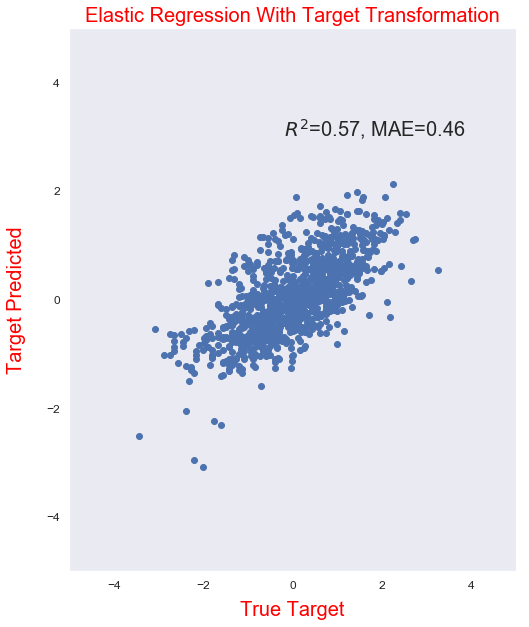

In [402]:
f, (ax0) = plt.subplots(1, 1, sharey=True, figsize=(8,10))

std_first = StandardScaler();
std_first.fit(X_train_First_OLS.values);

X_tr = std_first.transform(X_train_First_OLS.values);
X_te = std_first.transform(X_test_First_OLS.values)

alphavec = 10**np.linspace(-5,5,500)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_First_OLS)

test_set_pred = lasso_model.predict(X_te)

ax0.scatter(y_test_First_OLS, test_set_pred)

ax0.set_ylabel('Target Predicted', fontsize=20)
ax0.set_xlabel('True Target', fontsize=20)
ax0.set_title('Elastic Regression With Target Transformation',fontsize=20)
ax0.text(-.2,3.0, r'$R^2$=%.2f, MAE=%.2f' % (
    0.57, median_absolute_error(y_test_First_OLS, test_set_pred)),fontsize=20)
ax0.set_xlim([-5, 5])
ax0.set_ylim([-5, 5])

ax0.grid(False)

ax0.tick_params(labelsize=12)

ax0.xaxis.labelpad = 10
ax0.yaxis.labelpad = 20


ax0.yaxis.label.set_color('red')
ax0.xaxis.label.set_color('red')
ax0.title.set_color('red')


plt.savefig('ElasticWitTarget.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)


# EDA Section

In [197]:
airbnb_numeric_only_1_o_3 = airbnb_df_2[['bathrooms','bedrooms','accommodates']].copy(deep=True)

airbnb_numeric_only_2_o_3 = airbnb_df_2[['walk_score_of_100','transit_score_of_100','bike_score_of_100']].copy(deep=True)

airbnb_numeric_only_3_o_3 = airbnb_df_2[['number_of_reviews','review_scores_rating',\
                                 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
                                 'review_scores_communication','review_scores_location','review_scores_value']].copy(deep=True)
                                
airbnb_numeric_only_ROI = airbnb_df_2[['ROI']].copy(deep=True)



In [198]:
airbnb_uni_type = airbnb_df_2[['Apartment','Condominium','House','Townhouse','ROI']]
airbnb_location = airbnb_df_2[['Bayview','Bernal Heights','Castro','Chinatown','Civic Center / Van Ness','Crocker Amazon','Diamond Heights','Excelsior','Financial District','Glen Park','Golden Gate Park','Haight Ashbury','Inner Richmond','Inner Sunset','Lakeshore','Mission','Nob Hill','Noe Valley','North Beach','Ocean View Terrace','Outer Mission','Outer Richmond','Outer Sunset','Pacific Heights','Parkside','Potrero Hill','Presidio Heights','Russian Hill','Seacliff','South of Market','Twin Peaks','Visitacion Valley','West of Twin Peaks','Western Addition','ROI']]

In [ ]:

fig, ax = plt.subplots(figsize=(10,10))  
plt.style.use('default')
airbnb_numeric_only_1_o_3.boxplot();

In [ ]:

fig, ax = plt.subplots(figsize=(10,10))  
plt.style.use('default')
airbnb_numeric_only_2_o_3.boxplot()

In [ ]:

fig, ax = plt.subplots(figsize=(20,15))  
plt.style.use('default')
airbnb_numeric_only_3_o_3.boxplot()

In [ ]:


fig, ax = plt.subplots(figsize=(20,15))  
plt.style.use('default')
airbnb_numeric_only_ROI.boxplot();

In [ ]:
#Accomodation Data Distribution
ax = airbnb_numeric_only_1_o_3['accommodates'].hist(bins=10);
ax.set_xlabel("Accomodations");

In [ ]:
# #Accomodation Data Distribution
data_accom = np.log(airbnb_numeric_only_1_o_3['accommodates'])
ax = data_accom.hist(bins=10);
ax.set_xlabel("Accomodations");

In [ ]:
# #Accomodation Data Distribution
data_accom = np.log(airbnb_numeric_only_1_o_3['accommodates'])
ax = data_accom.hist(bins=10);
ax.set_xlabel("Accomodations");

In [ ]:
#Bathroom Data Distribution
ax = airbnb_numeric_only_1_o_3['bathrooms'].hist(bins=5);
ax.set_xlabel("Bathroom");

In [ ]:
y_trans_review = quantile_transform(airbnb_numeric_only_1_o_3['bathrooms'].values.reshape(-1, 1), output_distribution='normal').squeeze();

f, (ax0) = plt.subplots(1, 1);

f.set_figheight(10)
f.set_figwidth(15)

ax0.hist(y_trans_review, bins=10);

In [ ]:
#Bathroom Data Distribution
data_bath = np.log(airbnb_numeric_only_1_o_3['bathrooms']+1)
ax = data_bath.hist(bins=6);
ax.set_xlabel("Bathroom");

In [ ]:
# Accomodation Data Distribution
ax = airbnb_numeric_only_1_o_3['bedrooms'].hist(bins=10);
ax.set_xlabel("Bedrooms");

In [ ]:
#Histogram_Bike_Scores
ax = airbnb_numeric_only_2_o_3['bike_score_of_100'].hist(bins=10);
ax.set_xlabel("Bike Scores");

In [ ]:
#Histogram_Transit_Scores
ax = airbnb_numeric_only_2_o_3['transit_score_of_100'].hist(bins=20);
ax.set_xlabel("Transit Scores");

In [ ]:
y_trans_review = quantile_transform(airbnb_numeric_only_2_o_3['transit_score_of_100'].values.reshape(-1, 1), output_distribution='normal').squeeze();

f, (ax0) = plt.subplots(1, 1);

f.set_figheight(10)
f.set_figwidth(15)

ax0.hist(y_trans_review, bins=30);

In [ ]:
#Histogram_Walk_Scores
ax = airbnb_numeric_only_2_o_3['walk_score_of_100'].hist(bins=30);
ax.set_xlabel("Walk Scores");

In [ ]:
y_trans_review = quantile_transform(airbnb_numeric_only_2_o_3['walk_score_of_100'].values.reshape(-1, 1), output_distribution='normal').squeeze();

f, (ax0) = plt.subplots(1, 1);

f.set_figheight(10)
f.set_figwidth(15)

ax0.hist(y_trans_review, bins=30);

In [ ]:
# data_walk = np.log(airbnb_numeric_only_2_o_3['walk_score_of_100'])
# print(data_walk.shape)
# data_walk = data_walk[data_walk>4]
# print(data_walk.shape)
# #data_walk = np.cbrt(data_walk)
# ax = data_walk.hist(bins=30);
# ax.set_xlabel("Walk Scores");

In [ ]:
#Histogram_Number_of_Reviews
ax = airbnb_numeric_only_3_o_3['number_of_reviews'].hist(bins = 20);
ax.set_xlabel("Number of reviews");

In [ ]:
# box-cox transform


# Log power transform
data_review = np.log(airbnb_numeric_only_3_o_3['number_of_reviews']+1)
data_review=data_review[data_review!=0]
ax = data_review.hist(bins = 20);
ax.set_xlabel("Number of reviews");


In [ ]:
#Histogram_Walk_Scores
ax = airbnb_numeric_only_3_o_3['review_scores_accuracy'].hist(bins = 10);
ax.set_xlabel("Scores Accuracy");

In [ ]:
# data_walk = np.square(airbnb_numeric_only_3_o_3['review_scores_accuracy'])
# ax = data_walk.hist(bins = 10);
# ax.set_xlabel("Scores Accuracy");


lamb_accu=stats.boxcox_normmax(airbnb_numeric_only_3_o_3['review_scores_accuracy'])
print("Lambda:", lamb_accu)

y_t=(np.power(airbnb_numeric_only_3_o_3['review_scores_accuracy'], lamb_accu)-1)/ lamb_accu

plt.hist(y_t);

In [ ]:
#Histogram_Review_Scores_Checkin
ax = airbnb_numeric_only_3_o_3['review_scores_checkin'].hist(bins = 10);
ax.set_xlabel("Review Scores");

In [ ]:
lamb_review_score=stats.boxcox_normmax(airbnb_numeric_only_3_o_3['review_scores_checkin'])
print(lamb_review_score)

y_t=(np.power(airbnb_numeric_only_3_o_3['review_scores_checkin'], lamb_accu)-1)/ lamb_accu

plt.hist(y_t);

In [ ]:
#Histogram_Review_Scores_Clean
ax = airbnb_numeric_only_3_o_3['review_scores_cleanliness'].hist(bins = 10);
ax.set_xlabel("Scores Cleanliness");

In [ ]:
lamb_clean_score=stats.boxcox_normmax(airbnb_numeric_only_3_o_3['review_scores_cleanliness'])
print(lamb_clean_score)

y_t=(np.power(airbnb_numeric_only_3_o_3['review_scores_cleanliness'], lamb_clean_score)-1)/ lamb_clean_score

plt.hist(y_t);

In [ ]:
#Histogram_Review_Scores_Comms
ax = airbnb_numeric_only_3_o_3['review_scores_communication'].hist(bins = 10);
ax.set_xlabel("Scores Communication");

In [ ]:
lamb_score_comm_2=stats.boxcox_normmax(airbnb_numeric_only_3_o_3['review_scores_communication'])
print(lamb_score_comm_2)

airbnb_numeric_only_3_o_3['review_scores_communication']=(np.power(airbnb_numeric_only_3_o_3['review_scores_communication'], lamb_score_comm_2)-1)/ lamb_score_comm_2




In [ ]:
plt.hist(airbnb_numeric_only_3_o_3['review_scores_communication'])

In [ ]:
#Histogram_Review_Scores_Comms
ax = airbnb_numeric_only_3_o_3['review_scores_location'].hist(bins = 10);
ax.set_xlabel("Scores Location");

In [ ]:
#Histogram_Review_Scores_Rating
ax = airbnb_numeric_only_3_o_3['review_scores_rating'].hist(bins = 10);
ax.set_xlabel("Scores Rating");

In [ ]:
lamb_score_rating_2=stats.boxcox_normmax(airbnb_numeric_only_3_o_3['review_scores_rating'])
print(lamb_score_rating_2)

y_t=(np.power(airbnb_numeric_only_3_o_3['review_scores_rating'], lamb_score_rating_2)-1)/ lamb_score_rating_2

plt.hist(y_t);


In [ ]:
#Histogram_Review_Scores_Value
ax = airbnb_numeric_only_3_o_3['review_scores_value'].hist(bins = 15);
ax.set_xlabel("Scores Value");

In [ ]:
lamb_score_rating_3=stats.boxcox_normmax(airbnb_numeric_only_3_o_3['review_scores_value'])
print(lamb_score_rating_3)

y_t=(np.power(airbnb_numeric_only_3_o_3['review_scores_value'], lamb_score_rating_3)-1)/ lamb_score_rating_3

plt.hist(y_t);


In [ ]:
dataset

In [ ]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)


dataset = all_tier_air['ROI']

# calculate summary statistics
data_mean, data_std = mean(dataset), std(dataset)

# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

#Removed Outliers
dataset  = dataset[(dataset > lower) & (dataset < upper)]

#Histogram_Review_Scores_Value
# ax = airbnb_numeric_only_ROI.hist(figsize=(10,10), bins=60);

y_trans = quantile_transform(dataset.values.reshape(-1, 1), output_distribution='normal').squeeze();

f, (ax0, ax1) = plt.subplots(1, 2);

plt.tight_layout(pad=3.0)
plt.tick_params(labelsize=14)

f.set_figheight(10)
f.set_figwidth(15)

ax0.hist(dataset, bins=100);
ax0.set_ylabel('Probability',);
ax0.set_xlabel('Target');
ax0.set_title('ROI distribution');

ax1.hist(y_trans, bins=100);
ax1.set_ylabel('Probability');
ax1.set_xlabel('Target');
ax1.set_title('Transformed ROI distribution');




In [199]:
airbnb_numeric_only_1_o_3_ROI = airbnb_df_2[['bathrooms','bedrooms','accommodates','ROI']].copy(deep=True)

airbnb_numeric_only_2_o_3_ROI = airbnb_df_2[['walk_score_of_100','transit_score_of_100','bike_score_of_100','ROI']].copy(deep=True)

airbnb_numeric_only_3_o_3_ROI = airbnb_df_2[['number_of_reviews','review_scores_rating',\
                                 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
                                 'review_scores_communication','review_scores_location','review_scores_value','ROI']].copy(deep=True)
                                
#airbnb_numeric_only_ROI = airbnb_df[['ROI']].copy()

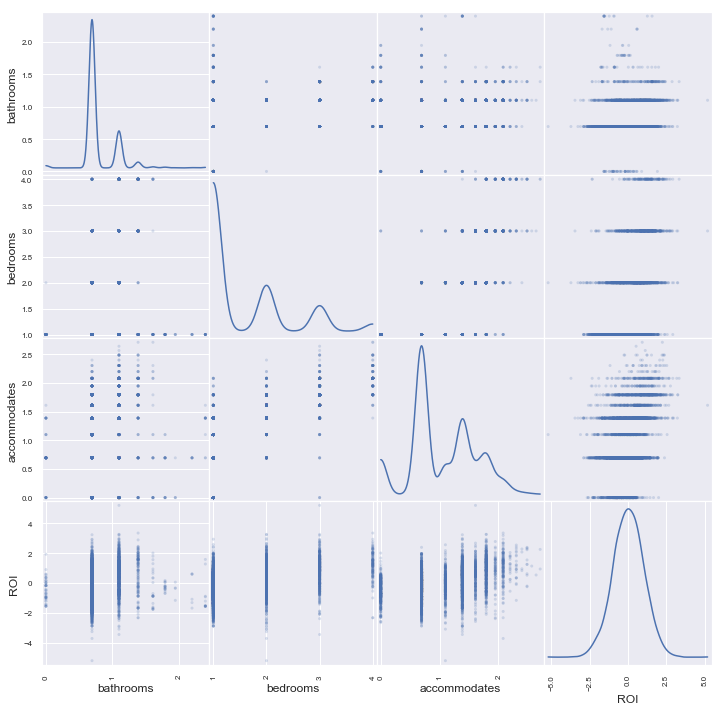

In [200]:

scatter_matrix(airbnb_numeric_only_1_o_3_ROI, alpha=0.2, figsize=(12, 12), diagonal='kde');

# Notes on Above
- Correlation between number of bathrooms and how many people we can accommodate
- Correlation between number of bedrooms and bathrooms
- No strong correlations between ROI and accomodations
- Number of people accommodated doesnt represent greater ROI

In [ ]:
scatter_matrix(airbnb_numeric_only_2_o_3_ROI, alpha=0.2, figsize=(12, 12), diagonal='kde');

In [ ]:


scatter_matrix(airbnb_numeric_only_3_o_3_ROI, alpha=0.2, figsize=(20, 20), diagonal='kde');

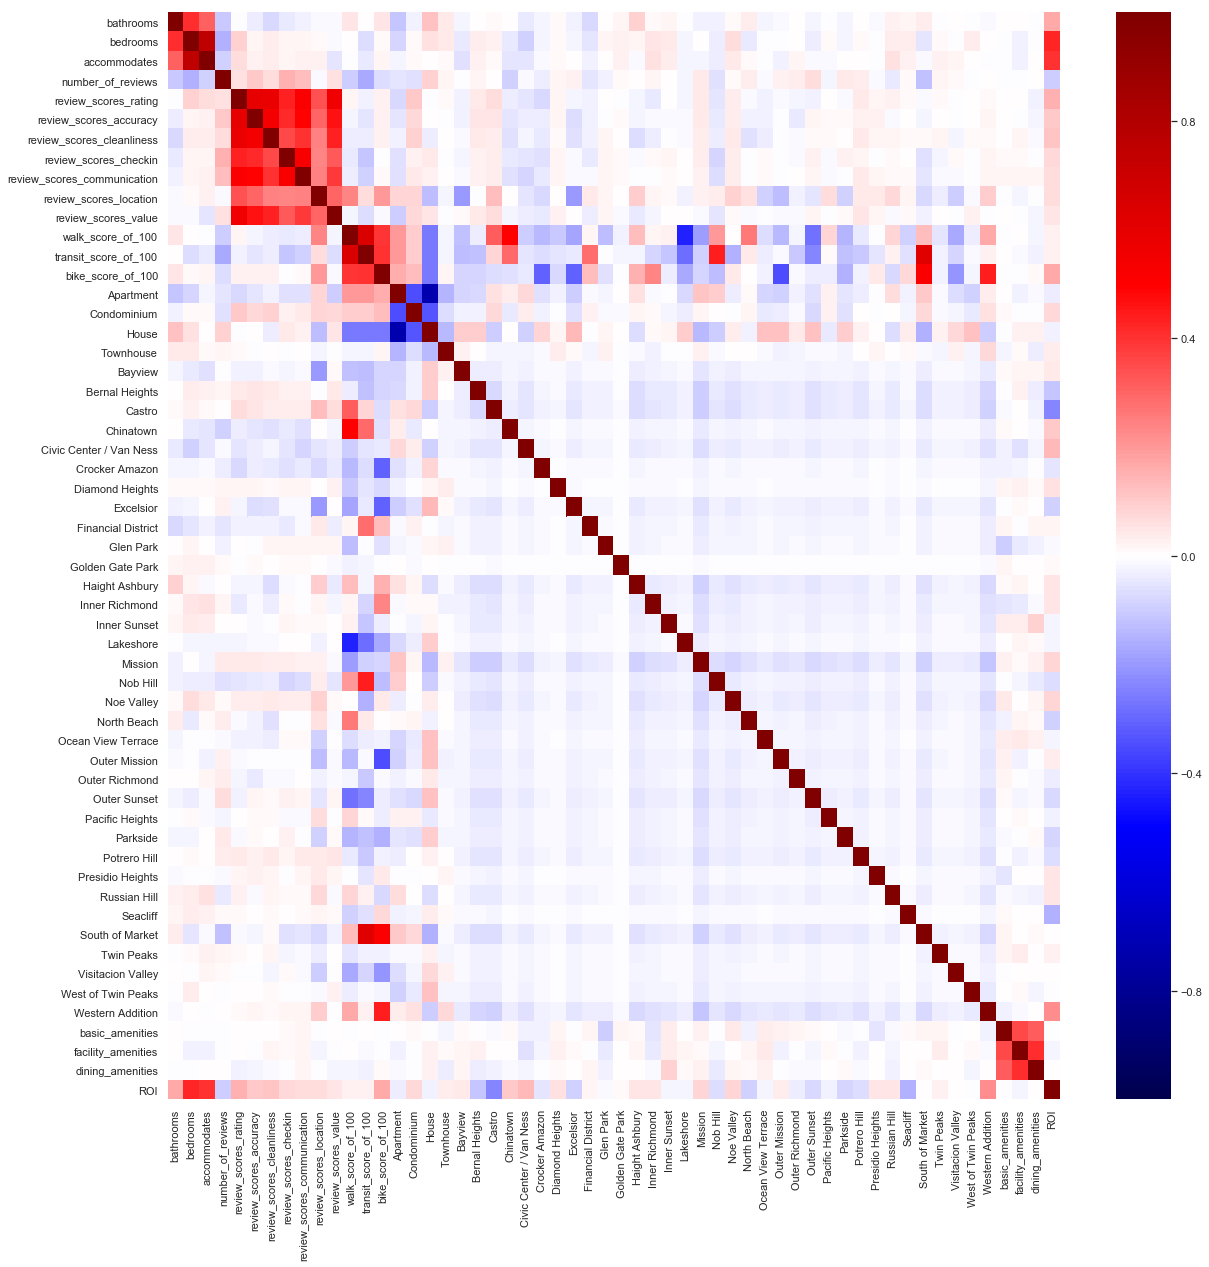

In [201]:
#Corr Matrix
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(airbnb_df_2.corr(), cmap="seismic", vmin=-1, vmax=1);

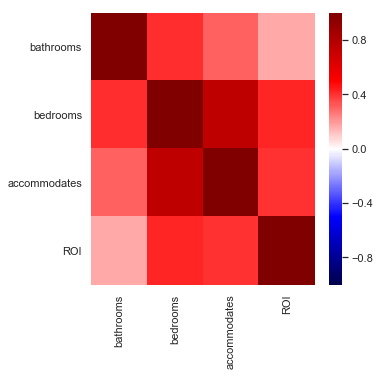

In [202]:
#Corr Matrix
fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(airbnb_numeric_only_1_o_3_ROI.corr(), cmap="seismic", vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

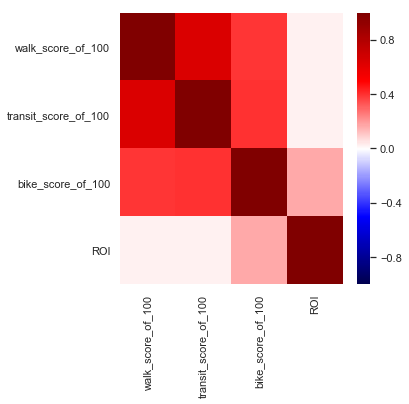

In [203]:
#Corr Matrix
fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(airbnb_numeric_only_2_o_3_ROI.corr(), cmap="seismic", vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

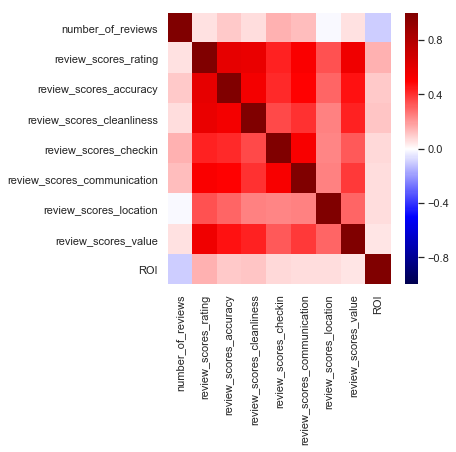

In [204]:
#Corr Matrix
fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(airbnb_numeric_only_3_o_3_ROI.corr(), cmap="seismic", vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

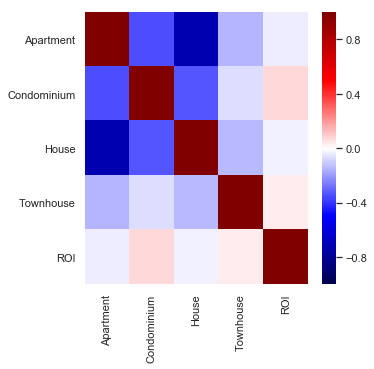

In [205]:
#Corr Matrix
fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(airbnb_uni_type.corr(), cmap="seismic", vmin=-1, vmax=1);

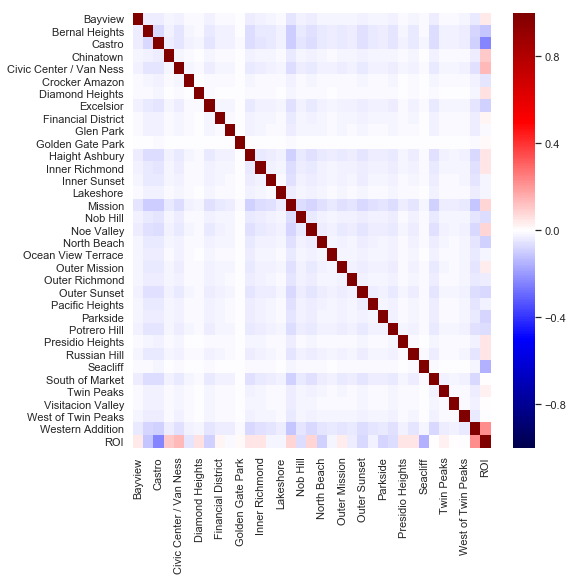

In [206]:
#Corr Matrix
fig, ax = plt.subplots(figsize=(8,8))  
sns.heatmap(airbnb_location.corr(), cmap="seismic", vmin=-1, vmax=1);

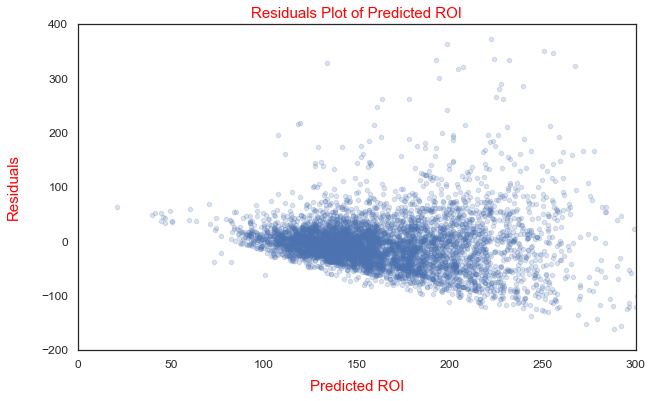

In [390]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis
test_df = all_tier_air.copy(deep=True)
test_df['ROI'] = all_tier_air['ROI']

X = test_df[test_df.columns[:-1]]
y = test_df.ROI   # predictor

lr = LinearRegression()
fit = lr.fit(X,y) # for later use

test_df['Predicted ROI']=fit.predict(X)
test_df['Residuals']=test_df.ROI-test_df['Predicted ROI']
with sns.axes_style('white'):
    plot=test_df.plot(kind='scatter',
                  x='Predicted ROI',y='Residuals',alpha=0.2,figsize=(10,6), fontsize=12)

plot.set_ylabel('Residuals',fontsize=15)
plot.set_xlabel('Predicted ROI', fontsize=15)
plot.set_title('Residuals Plot of Predicted ROI',fontsize=15)

plot.tick_params(labelsize=12)

plot.xaxis.labelpad = 10
plot.yaxis.labelpad = 20

plot.set_xlim([0, 300])
plot.set_ylim([-200, 400])


plot.yaxis.label.set_color('red')
plot.xaxis.label.set_color('red')
plot.title.set_color('red')

plt.savefig('Residual Plot - Non Transformed ROI.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

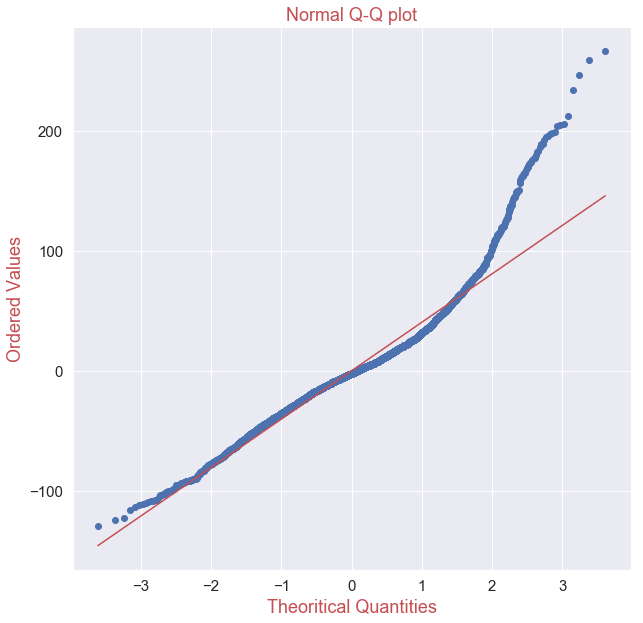

In [232]:
fig1 = plt.gcf()
stats.probplot(test_df['Residuals'], dist="norm", plot=plt);
plt.rcParams["figure.figsize"] = (10,10)
plt.title("Normal Q-Q plot", fontsize=18, color='r');

plt.xlabel('Theoritical Quantities', fontsize=18, color='r')
plt.ylabel('Ordered Values', fontsize=18, color='r')
plt.tick_params(labelsize=15)
plt.show();

fig1.savefig('NormalQ-QPlot.jpg', dpi=100, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

The target for our ROI dataset is Return On Investment, which is Continuous, it can be negative. 

* Get Dataset, run.info, what type my data is, look at heat map, postively and negatively corelated things, pair plot, general
patterns, box and violen plots, categorical bar charts, Look at how patterns change

Create a hypothesis of what my linear model will tell me

Fit Basic Model, before feature extraction, Look at features, and evaluation 

Linear regression assumptions, residuals are normall distributed

Grid search and standard scalar



Rsquared:

Tells us there is variance in our model, we don't like variance and we want to be certain of ourselves

Mean squared error is nice, because its the first step towards root mean squared error


RMSE -> Lets square the errors, to get the mean, get the sum and divide by the total items you have. The average miss my model makes, between 

It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values, average prediction is 45 points away from the tru

    


# Cross Validation and Elastic Regularization

### Standard-scaling Features (A Must for Regularization!)

In [257]:
#Separate our features from our target
X = airbnb_df_2[airbnb_df_2.columns[:-1]]

y = airbnb_df_2['ROI']

In [258]:
X = X.reset_index(drop=True)

In [259]:
y = y.reset_index(drop=True)

In [261]:
## This step fits the Standard Scaler to the training data
std = StandardScaler();
std.fit(X_train.values);

In [262]:
## This step applies the scaler to the train set.
X_tr = std.transform(X_train.values);

In [263]:
## Apply the scaler to the test set
X_te = std.transform(X_test.values)

In [264]:
#Check Training Data Type
type(X_train), type(X_tr)

(pandas.core.frame.DataFrame, numpy.ndarray)

In [265]:
selected_columns = X.columns

In [266]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-5,5,500)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000e-05, 1.04723e-05, ..., 9.54904e+04, 1.00000e+05]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [267]:
lasso_model.alpha_


0.004418659956385941

In [268]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_));

In [269]:
test_set_pred = lasso_model.predict(X_te)

In [270]:
#Mean Absolute Error (MAE)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.5793731853832663

In [271]:
r2_score(y_test, test_set_pred)

0.45351499283221375

In [272]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec_elastic = 10**np.linspace(-5,5,500)

elastic_model = ElasticNetCV(cv=5)
elastic_model.fit(X_tr, y_train)

print(elastic_model.alpha_)

# These are the (standardized) coefficients found
# when it refit using that best alpha

test_set_pred = elastic_model.predict(X_te)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

r2_score(y_test, test_set_pred)

0.008665236550457155


0.4536469696349781

In [273]:
mae(y_test, test_set_pred)

0.5793224019985055

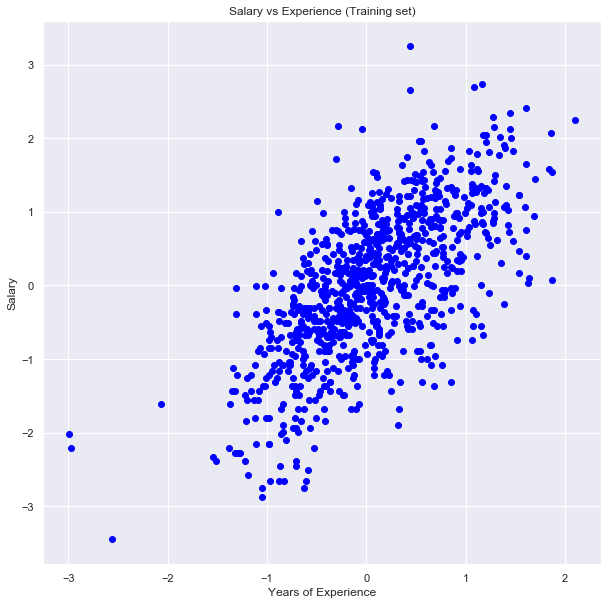

In [274]:
plt.scatter(test_set_pred, y_test, color = 'Blue')
plt.title('Salary vs Experience (Training set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

In [275]:
list(zip(X_train.columns, elastic_model.coef_));

In [276]:
feature_cofficient_list = list(zip(X_train.columns, elastic_model.coef_))

In [277]:
df_feat_coef = pd.DataFrame(feature_cofficient_list,columns=['Feature','Weight'])

In [278]:
df_feat_coef['Weight'] = df_feat_coef['Weight'] / std.scale_

In [279]:
df_feat_coef.sort_values(by=['Weight'],ascending=False, inplace=True);

In [280]:
Top_Features = list(df_feat_coef['Feature'][0:11])

In [281]:
Top_Scores =  list(df_feat_coef['Weight'][0:11])

In [282]:
Top_Scores, Top_Features

([1.1677070194752404,
  0.9840224309793787,
  0.8350655846061912,
  0.6186404357333747,
  0.580230602540393,
  0.4651098984520614,
  0.3679357995501367,
  0.3582061358499789,
  0.3153658115458932,
  0.2783278653302475,
  0.21315220253257552],
 ['Chinatown',
  'Civic Center / Van Ness',
  'Diamond Heights',
  'Western Addition',
  'Bayview',
  'Presidio Heights',
  'accommodates',
  'bedrooms',
  'Outer Mission',
  'Financial District',
  'Russian Hill'])

In [283]:
lamb = []
alpha = []
lm_reg_mse =[]
lm_reg_r2=[]
kf=5

for n in 10**np.linspace(-2,2,500):
    for k in np.linspace(0,1,10):
        lm_reg =ElasticNet(alpha =n,l1_ratio=k)
        lamb.append(n)
        alpha.append(k)
        lm_reg_mse.append(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='neg_mean_squared_error')))
        lm_reg_r2.append(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\moham\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

KeyboardInterrupt: 

## Data transformation with held out data

# Elastic Net 
- Linear regression with combined L1 and L2 priors as regularizer.
- alpha = a + b and l1_ratio = a / (a + b)
- ratio = 0<=l1_ratio <=1
- l1_ratio = The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.

In [290]:
d = {'lambda':lamb,
     'alpha':alpha,
     'mse':lm_reg_mse,
     'Rsquared':lm_reg_r2}

df_elastic_net_variables = pd.DataFrame(d)

In [291]:
df_elastic_net_variables.sort_values(by=['Rsquared'],ascending=False, inplace=True);

In [292]:
df_elastic_net_variables.head(10)

,Rsquared,alpha,lambda,mse
3,0.131578,0.333333,0.010000,-0.843376
13,0.131047,0.333333,0.010186,-0.843991
23,0.130475,0.333333,0.010376,-0.844641
33,0.129900,0.333333,0.010569,-0.845295
4,0.129614,0.444444,0.010000,-0.845604
43,0.129313,0.333333,0.010766,-0.845962
14,0.129023,0.444444,0.010186,-0.846258
53,0.128715,0.333333,0.010967,-0.846639
24,0.128480,0.444444,0.010376,-0.846869
63,0.128110,0.333333,0.011171,-0.847324
